In [33]:
# Import modules

from music21 import corpus, instrument, converter
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import itertools as iter
import re

from dimod import BinaryQuadraticModel
import dimod.generators
from dwave.samplers import SteepestDescentSolver
from dwave.system import DWaveSampler, EmbeddingComposite, LazyFixedEmbeddingComposite, FixedEmbeddingComposite
from minorminer import find_embedding
from dwave_networkx import pegasus_graph

from boundaryDetection import extractPhrases
from plotters import plotHistogram


identifier = "haydn_opus1no1_movement1"

excerpt = converter.parse(f"../Pickles/{identifier}.musicxml")
phrases = pickle.load(open(f"../Pickles/{identifier}_phrases.pkl", "rb"))
G = pickle.load(open(f"../Pickles/{identifier}_graph.pkl", "rb"))
bqm = pickle.load(open(f"../Pickles/{identifier}_bqm.pkl", "rb"))

In [ ]:
# https://www.music21.org/music21docs/about/referenceCorpus.html#referencecorpus

beethoven = "beethoven/opus74.mxl"

score = corpus.parse("haydn/opus1no1/movement1.mxl")

score.write(fmt="musicxml", fp=f"../Pickles/{identifier}")

In [ ]:
# Extract phrases from score

phrases = extractPhrases(score, 0.3, (0.3, 0.6))
pickle.dump(phrases, open(f"../Pickles/{identifier}_phrases.pkl", "wb"))

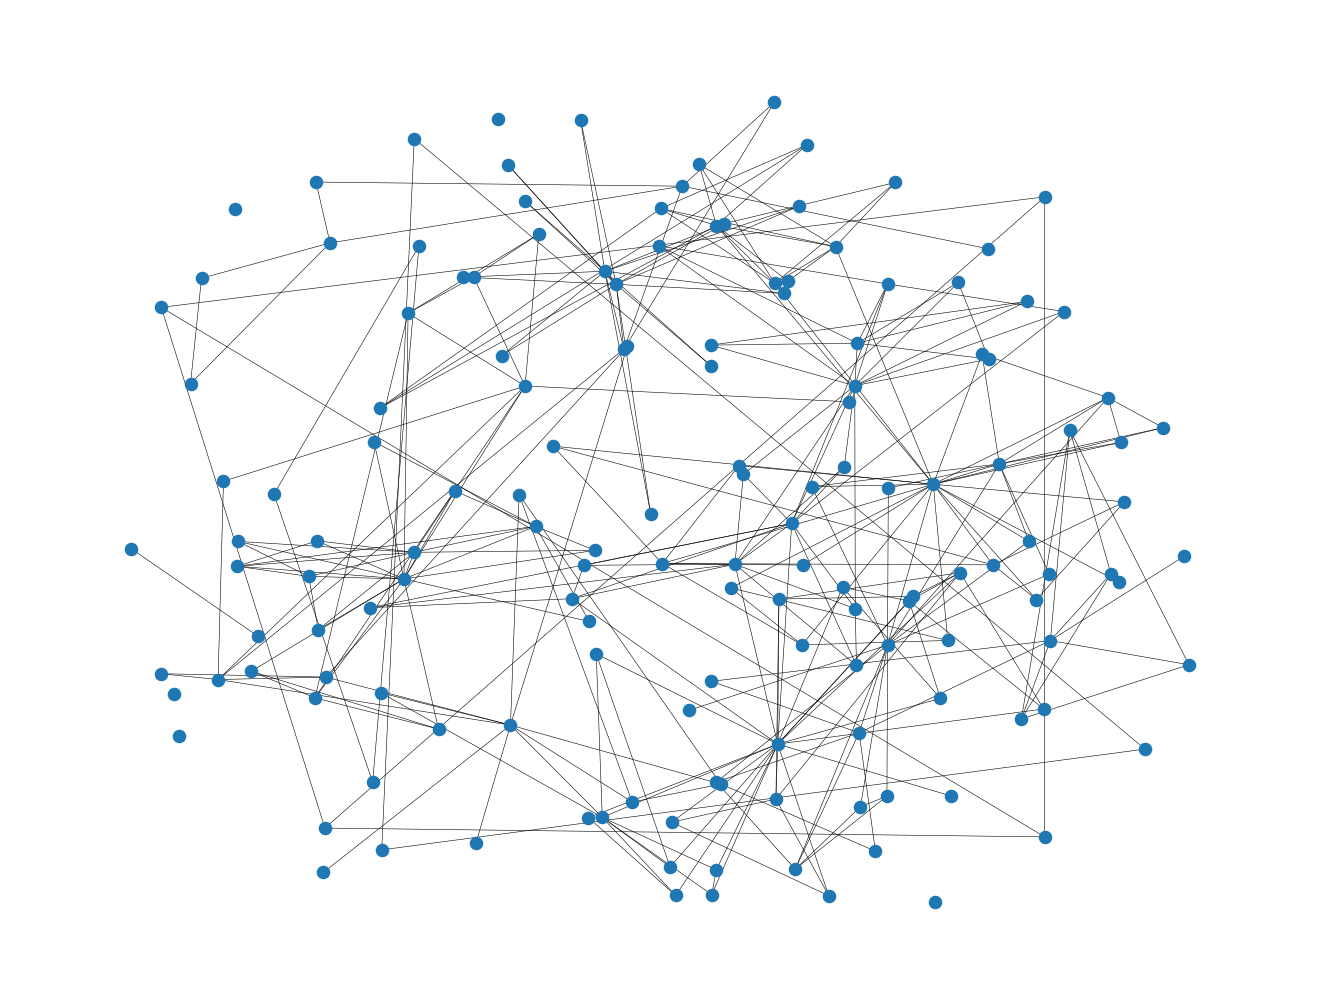

In [17]:
# Load created graph

G = pickle.load(open(f"../Pickles/{identifier}_graph.pkl", "rb"))
pos = nx.spring_layout(G, k=0.5, seed=8)
nx.draw(G, pos=pos, node_size=15, width=0.2)

In [ ]:
# Create colouring problem BQM

instruments = {"red":instrument.Flute, "green":instrument.Oboe, "blue":instrument.Bassoon}

bqm = BinaryQuadraticModel(vartype="BINARY")
allPhrases = [phrase for part in phrases for phrase in part]

# Add all vertices for each colour
bqm.add_variables_from([(f"{phrase.id}_{i}", 0)for phrase in allPhrases for i in instruments.keys()])

for phrase in allPhrases:
    # Each vertex coloured at most once
    bqm.add_linear_inequality_constraint([(f"{phrase.id}_{i}",1) for i in instruments.keys()], ub=1, lagrange_multiplier=10, label="One colour per vertex")
    # Maximise vertex weighting
    bqm.add_linear_from([(f"{phrase.id}_{i}", -phrase.entropy) for i in instruments.keys()])

for u, v, d in G.edges.data():
    # Adjacent vertices have different colours
    bqm.add_quadratic_from([(f"{u}_{i}", f"{v}_{i}", 100) for i in instruments.keys()])
    # Maximise edge weighting
    bqm.add_quadratic_from([(f"{u}_{i}", f"{v}_{j}", -d["weight"]) for i,j in iter.product(instruments.keys(), repeat=2)])

#pickle.dump(bqm, open(f"../Pickles/{identifier}_bqm.pkl", "wb"))

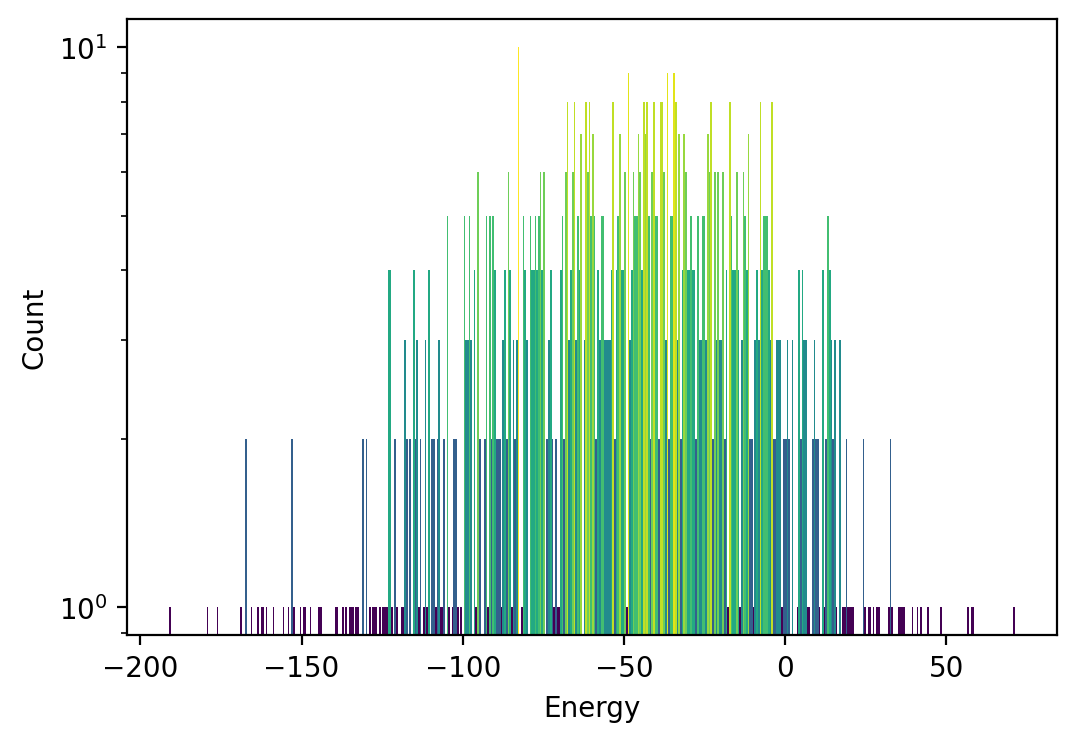

In [4]:
# Solve classically
sd = SteepestDescentSolver().sample(bqm, num_reads=1000).to_pandas_dataframe(True) # Try more than one, simulated annealing
plotHistogram(sd)
# Compare energies from different methods
# Just because it doesn't crash doesn't mean it passed
#pickle.dump(df, open(f"../Pickles/{identifier}_df.pkl", "wb"))

In [37]:
embedding = find_embedding(bqm.to_networkx_graph(), pegasus_graph(16))
print(embedding)
pickle.dump(embedding, open(f"../Pickles/{identifier}_embedding.pkl", "wb"))

{'Cello_10_0': [521, 520, 522], 'Cello_10_1': [686, 5088, 5012], 'Cello_10_2': [641, 640, 642, 5027], 'Viola_6_0': [4967, 551], 'Viola_6_1': [4907, 610, 4908, 4968], 'Viola_6_2': [4938, 4937, 596], 'Viola_7_0': [5207, 5313, 5208, 612, 611, 5312], 'Viola_7_1': [5298, 687, 5299, 5297, 492], 'Viola_7_2': [5223, 5222, 777], 'Violin II_7_0': [4892, 581, 490], 'Violin II_7_1': [4982, 5073, 671], 'Violin II_7_2': [4952, 4953, 731], 'Violin I_5_0': [5162, 5070, 597, 5163, 806, 805, 5164, 5165, 5072, 1151, 5071, 491, 1150], 'Violin I_5_1': [5043, 5042, 5041, 281, 5044, 656, 1121, 657, 5253, 776, 716, 5103, 5045, 655, 5160, 5148, 4895], 'Violin I_5_2': [5057, 536, 5059, 5087, 5058, 5060, 5061, 745, 761, 746, 747, 5056, 5055, 5193, 401, 748, 506], 'slack_One colour per vertex_0': [4981, 416, 5518, 417, 1721, 5132, 5133, 5134, 5135, 1900, 1077, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 2307, 5262, 5263, 4841, 5264, 1257, 1258, 460, 459, 1722, 5348, 1736, 1735, 2246, 2247, 2248, 5049, 386, 4921, 19

C:\Users\Lucas\AppData\Local\Temp\ipykernel_14628\1752598516.py:1: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  embedding = find_embedding(bqm.to_networkx_graph(), pegasus_graph(16))


In [38]:
fixed = FixedEmbeddingComposite(DWaveSampler(), embedding)
results = fixed.sample(bqm, num_reads=100, label=f"Haydn {100} reads").to_pandas_dataframe(True)
plotHistogram(results)

DisconnectedChainError: chain for Violin I_5_2 is not connected

{'Cello_10_1': (5188, 2397, 5187), 'Cello_10_0': (5143, 5144), 'Cello_10_2': (5158, 5159), 'Cello_11_1': (5007, 2351, 5008), 'Cello_11_0': (5037, 2471), 'Cello_11_2': (5067, 5068), 'Cello_12_1': (5083, 5082), 'Cello_12_0': (5128, 2547), 'Cello_12_2': (2501, 5113), 'Cello_13_1': (4918, 2531, 4917), 'Cello_13_0': (5053, 2261, 5052, 2260, 5054), 'Cello_13_2': (4993, 2666, 2546, 4992), 'Cello_14_1': (4813, 4812), 'Cello_14_0': (4798, 4799, 2395), 'Cello_14_2': (2515, 4783, 2516), 'Cello_15_1': (5456, 5455, 5457, 2098, 2099), 'Cello_15_0': (5322, 2262, 5277, 2338, 5321, 2339), 'Cello_15_2': (5397, 2008, 5396, 5395, 5398, 2009, 5500, 5590), 'Cello_16_1': (5561, 2309, 5560), 'Cello_16_0': (2173, 2174), 'Cello_16_2': (5605, 5606, 2039, 1934), 'Cello_17_1': (3488, 1562, 1488), 'Cello_17_0': (1532, 1533, 3623), 'Cello_17_2': (1608, 1607, 3653, 3652, 1444), 'Cello_18_1': (3822, 2345), 'Cello_18_0': (3942,), 'Cello_18_2': (2360, 3927), 'Cello_19_1': (5608,), 'Cello_19_0': (2459, 5668), 'Cello_19_2

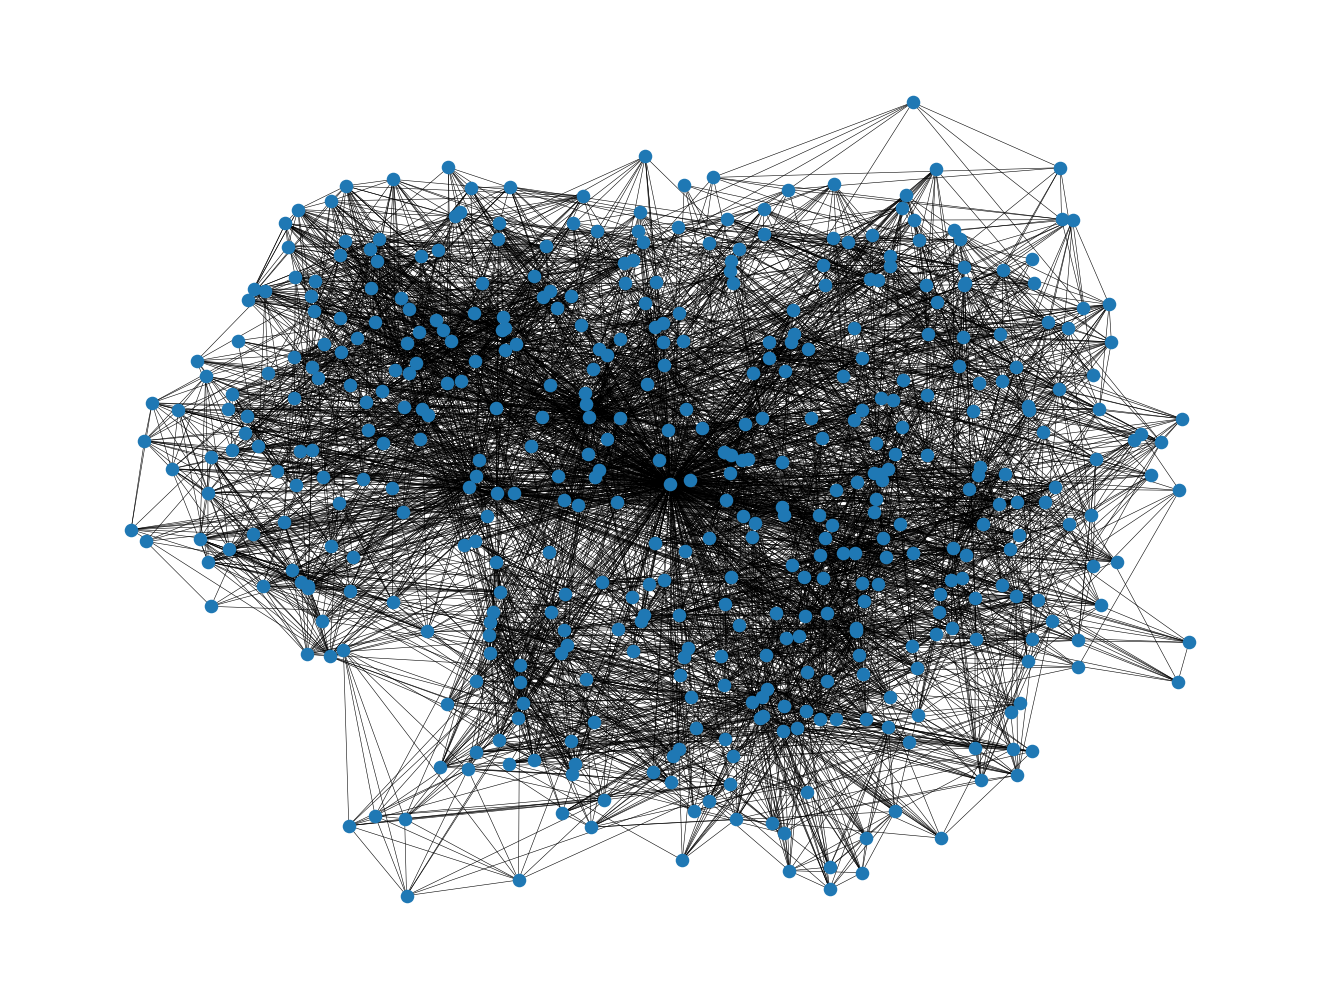

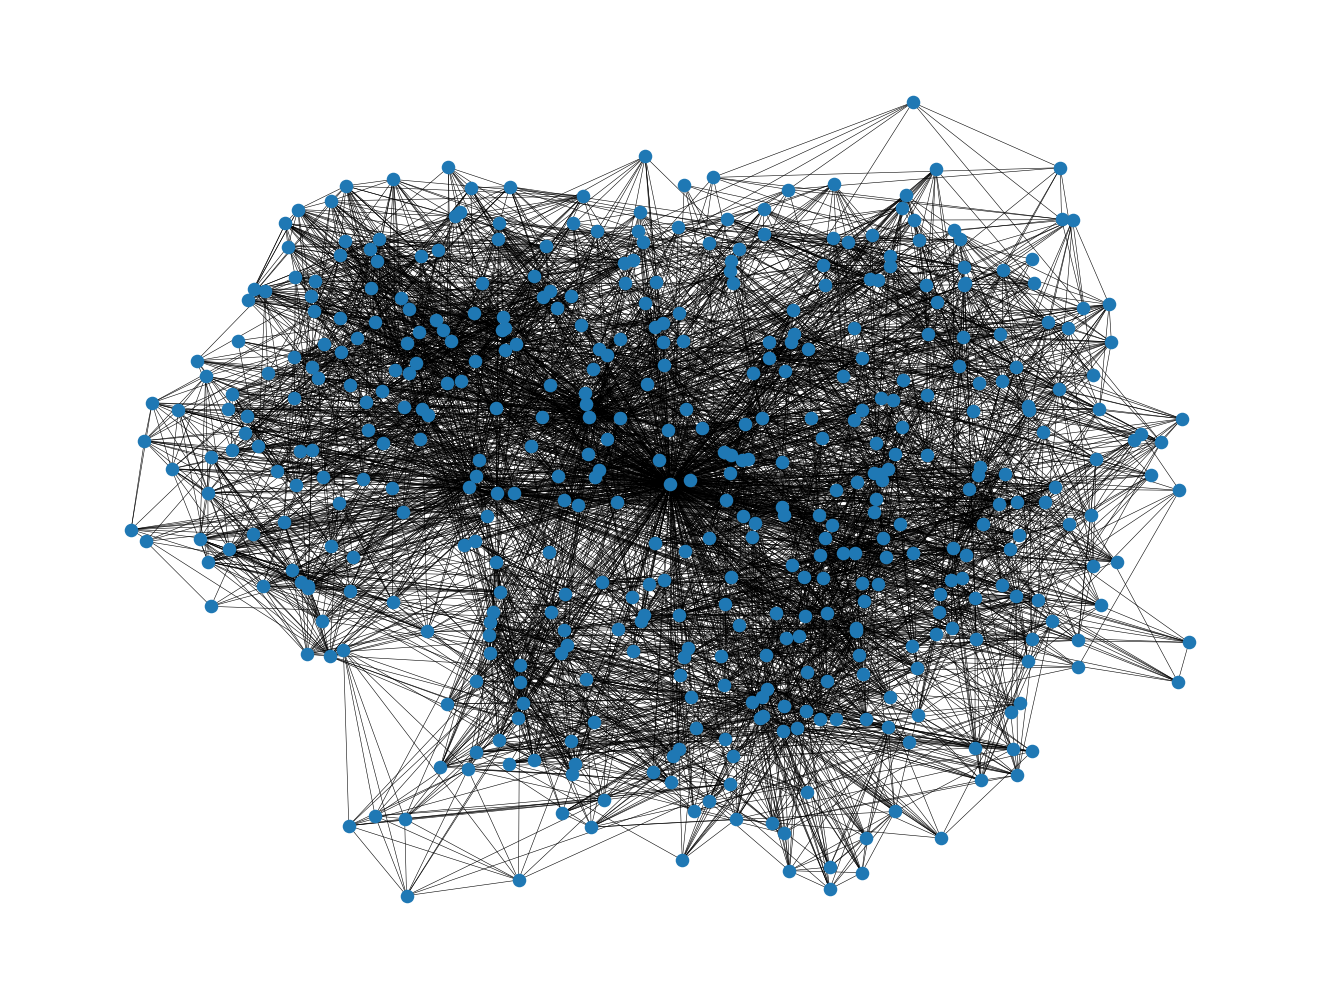

In [ ]:
S = sampler.to_networkx_graph()
Spos = nx.spring_layout(S, k=0.5, seed=8)
plt.figure(1)
nx.draw(S, Spos, node_size=15, width=.2)
pickle.dump(sampler.embedding, open(f"../Pickles/{identifier}_embedding.pkl", "wb"))
sampler2 = FixedEmbeddingComposite(DWaveSampler(), P)
plt.figure(2)
nx.draw(sampler2.to_networkx_graph(), Spos, node_size=15, width=.2)
#asdsda = sampler2.sample(bqm, num_reads=5, label=f"Haydn {5} reads").to_pandas_dataframe(True)

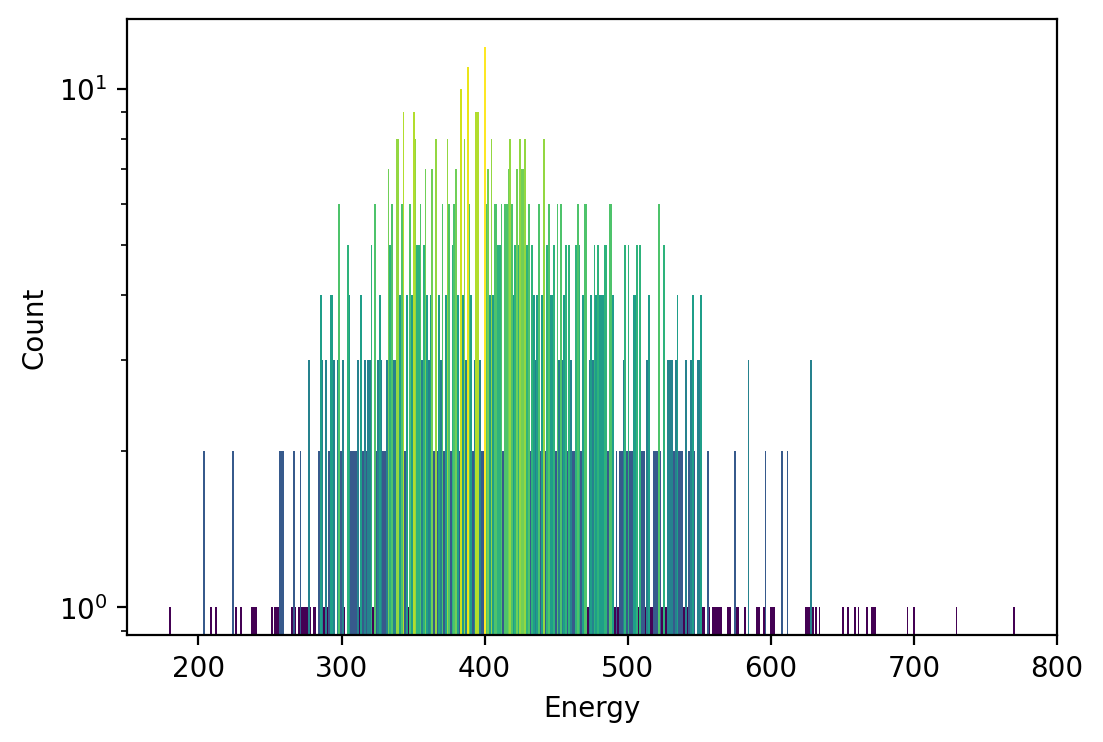

In [8]:
reads = [1000]

for r in reads:
    df = sampler.sample(bqm, num_reads=r, label=f"Haydn {r} reads").to_pandas_dataframe(True)
    plotHistogram(df)

In [5]:
print(df.sort_values("energy").head())

                                                sample      energy  \
273  {'Cello_10_0': 0, 'Cello_10_1': 0, 'Cello_10_2...  163.611026   
543  {'Cello_10_0': 0, 'Cello_10_1': 1, 'Cello_10_2...  229.123937   
68   {'Cello_10_0': 0, 'Cello_10_1': 0, 'Cello_10_2...  233.154792   
121  {'Cello_10_0': 1, 'Cello_10_1': 0, 'Cello_10_2...  252.013859   
11   {'Cello_10_0': 0, 'Cello_10_1': 0, 'Cello_10_2...  252.069105   

     num_occurrences  chain_break_fraction  
273                1              0.004405  
543                1              0.006608  
68                 1              0.013216  
121                1              0.004405  
11                 1              0.013216  


In [ ]:
# Show results
def processNode(node):
    groups = re.match(r"(.*_\d+)_(\w+)", node).groups()
    return groups

#print(df.head())
print(df.sort_values("energy").head())

sample = df["sample"][0]
chosen = {processNode(x)[0]:processNode(x)[1] for x in sample if sample[x] == 1}

plt.figure(0)
pos = nx.spring_layout(G, k=0.5, seed=8)
nx.draw_networkx_edges(G, pos, width=0.2)
nx.draw_networkx_nodes(G, pos, nodelist=chosen.keys(), node_color=chosen.values(), node_size=15)

plt.figure(2, figsize=(16,8))

for node in G.nodes():
    if node in chosen:
        G.nodes[node]["colour"] = chosen[node]
    else:
        G.nodes[node]["colour"] = "black"
pos = nx.multipartite_layout(G, "colour", "horizontal", 2)

nx.draw_networkx_nodes(G, pos, node_color=[G.nodes[node]["colour"] for node in G.nodes()], node_size=[10*(p.entropy+.1) for p in allPhrases])
nx.draw_networkx_edges(G, pos, width=[d["weight"]/10 for _, _, d in G.edges.data()])
#plt.savefig(f"../Figures/{identifier}_colouredGraph.pdf", pad_inches=0, bbox_inches="tight")

In [ ]:
# Solve on QPU

def solveWeightedMIS(G: nx.Graph, weights: list[tuple] = [], sampler=EmbeddingComposite(DWaveSampler()), num_reads: int = 100, strength_multiplier: float = 2) -> pd.DataFrame:
    bqm = dimod.generators.maximum_weight_independent_set(G.edges, weights, strength_multiplier=strength_multiplier)
    sampler = sampler
    sampleset = sampler.sample(bqm, num_reads = num_reads)
    return sampleset.to_pandas_dataframe(True)

df = solveWeightedMIS(G, phraseEntropies, num_reads=1000)

In [ ]:
# Final arrangement

parts = {}
for col, inst in instruments.items():
    part = stream.Part()
    #part.append()
    parts[col] = part

for phrase in [phrase for part in phraseLists for phrase in part]:
    if phrase.id in chosen:
        parts[chosen[phrase.id]].mergeElements(phrase.notes.stream()) # Focus on JUST NOTES for now 

arrangement = stream.Score(parts.values())
arrangement.show("midi")
arrangement.show()

In [ ]:

#arrangement.write(fmt="musicxml.pdf", fp="../Figures/poly.pdf", dpi=300)

# TODO: Allow specification of instrument for each part
# TODO: Bias selection of phrases to specific parts (e.g. by checking ambitus)
# TODO: Add meaningful edge weightings
# TODO: Find interesting constraints to add to BQM
# TODO: Are there more efficient ways to add constraints?